In [1]:
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

# Homomorphic Encrypted LeNet-1
This notebook will show a very practical example of running the famous LeNet-1 DL model directly on encrypted data.

![scheme](HE_processing.png)

## Homomorphic encryption operations
First of all, we will look at Pyfhel, a Python library which wraps SEAL, one of the most used frameworks for HE.
Pyfhel supports the BFV scheme, so, it is the one that we will use.

In [2]:
from Pyfhel import Pyfhel, PyPtxt, PyCtxt

HE = Pyfhel()
HE.contextGen(p=65537, m=4096)
HE.keyGen()

print(HE)

<Pyfhel obj at 0x7fdef58d36b0, [pk:Y, sk:Y, rtk:-, rlk:-, contx(p=65537, m=4096, base=2, sec=128, dig=64i.32f, batch=False)]>


In [3]:
a = 127.15717263
b = -2.128965182
ctxt1 = HE.encryptFrac(a)
ctxt2 = HE.encryptFrac(b)

ctxtSum = ctxt1 + ctxt2
ctxtSub = ctxt1 - ctxt2
ctxtMul = ctxt1 * ctxt2

resSum = HE.decryptFrac(ctxtSum)
resSub = HE.decryptFrac(ctxtSub) 
resMul = HE.decryptFrac(ctxtMul)

print(f"Expected sum: {a+b}, decrypted sum: {resSum}")
print(f"Expected sub: {a-b}, decrypted sum: {resSub}")
print(f"Expected mul: {a*b}, decrypted sum: {resMul}")

Expected sum: 125.028207448, decrypted sum: 125.02820744784549
Expected sub: 129.286137812, decrypted sum: 129.28613781183958
Expected mul: -270.7131931708334, decrypted sum: -270.7131931686308


In [4]:
print(f"Starting Noise Budget: {HE.noiseLevel(ctxt1)}")

print(f"sum Noise Budget: {HE.noiseLevel(ctxtSum)}")
print(f"prod Noise Budget: {HE.noiseLevel(ctxtMul)}")

Starting Noise Budget: 82
sum Noise Budget: 81
prod Noise Budget: 55


In [5]:
ptxt1 = HE.encodeFrac(-2.128965182)

print(f"ctxt-ptxt prod Noise Budget: {HE.noiseLevel(ctxt1 * ptxt1)}")

ctxt-ptxt prod Noise Budget: 80


## LeNet-1
The LeNet-1 is a small CNN developed by LeCun et al. It is composed of 5 layers: a convolutional layer with 4 kernels of size 5x5 and tanh activation, an average pooling layer with kernel of size 2, another convolutional layer with 16 kernels of size 5x5 and tanh activation, another average pooling layer with kernel of size 2, and a fully connected layers with size 192x10. 

The highest value in the output tensor corresponds to the label LeNet-1 associated to the input image. 

For this tutorial we will use the MNIST dataset.

In [6]:
transform = transforms.ToTensor()

test_set = torchvision.datasets.MNIST(
    root = './data',
    train=False,
    download=True,
    transform=transform
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=50,
    shuffle=True
)

## Approximating
As we know, there are some operations that cannot be performed homomorphically on encrypted values. Most notably, these operations are division and comparison. It is possible to perform only linear functions.

Consequently, in the LeNet-1 scheme we used, we can not use `tanh()`. This is because we cannot apply its non-linearities.


One of the most common approach is to replace it with a simple polynomial function, for example a square layer (which simply performs $x \rightarrow x^2$).

We define the model with all the non-linearities removed **approximated**. This model can be re-trained, and it will be ready to be used on encrypted values.

In [7]:
class Square(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, t):
        return torch.pow(t, 2)

lenet_1_approx = torch.load("LeNet1_Approx_single_square.pt")
lenet_1_approx.to("cpu")

Sequential(
  (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (1): Square()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(4, 12, kernel_size=(5, 5), stride=(1, 1))
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=192, out_features=10, bias=True)
)

## Encoding
From the applicative point of view, we have two options on how we want our Torch model to run on encrypted values:
  1. Modify Torch layers code in order to be fully compatible with arrays of Pyfhel ciphertexts/encoded values;
  2. Create the code for the general blocks of LeNet-1 (convolutional layer, linear layer, square layer, flatten...)
  
Let's remember that, in order to be used with the encrypted values, also the weights of the models will have to be **encoded**. This means that each value in the weights of each layer will be encoded in a polynomial.

In [8]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

We can now use a function to "convert" a PyTorch model to a list of sequential HE-ready-to-be-used layers (`sequential`):

In [9]:
from pycrcnn.he.HE import BFVPyfhel
from pycrcnn.model.sequential import Sequential

## Encrypted processing

Let's list the activities that we will now do:
  1. Create a PyCrCNN BFV HE context, specifiying the encryption parameters `m` (polynomial modulus degree) and `p` (plaintext modulus). Let's remember that `q` will be chosen automatically in order to guarantee a 128-bit RSA equivalent security;
  2. Convert our Torch approximated model to a list of layers able to work on matrices of encrypted values. The weights will be encoded;
  3. Encrypt an image from our testing set;
  4. Verify that the final classification result is correct.

In [17]:
import matplotlib.pyplot as plt

images, labels = next(iter(test_loader))

sample_image = images[0]
sample_label = labels[0]

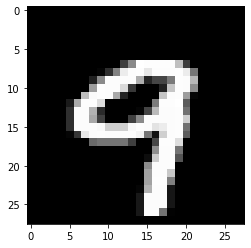

In [18]:
plt.imshow(sample_image[0], cmap='gray', interpolation='none')

In [19]:
sample_label

tensor(9)

We will create two PyCrCNN HE contexts: the one we will use to encrypt the image (`HE_Client`), and the one we will use to process the encrypted image (`HE_Server`). We will need to transfer the public key and the relinearization key in order to allow the server to compute some operations on encrypted data.

In [13]:
n = 4096
p = 9539831

HE_Client = BFVPyfhel(m=n, p=p)
HE_Client.generate_keys()
HE_Client.generate_relin_keys()

public_key = HE_Client.get_public_key()
relin_key  = HE_Client.get_relin_key()


HE_Server = BFVPyfhel(m=n, p=p)
HE_Server.load_public_key(public_key)
HE_Server.load_relin_key(relin_key)

Now, we create an encoded model starting from the approximated LeNet1.

In [20]:
lenet1_approx_encoded = Sequential(HE_Server, lenet_1_approx)
encrypted_image = HE_Client.encrypt_matrix(sample_image.unsqueeze(0).numpy())

In [15]:
with torch.no_grad():
    expected_output = lenet_1_approx(sample_image.unsqueeze(0))

In [16]:
start_time = time.time()
encrypted_output = lenet1_approx_encoded(encrypted_image, debug=True)

requested_time = round(time.time() - start_time, 2)

result = HE_Client.decrypt_matrix(encrypted_output)
difference = expected_output.numpy() - result

print(f"\nThe encrypted processing of one image requested {requested_time} seconds.")
print(f"\nThe expected result was:")
print(expected_output)

print(f"\nThe actual result is: ")
print(result)

print(f"\nThe error is:")
print(difference)    

Passed layer: <pycrcnn.convolutional.convolutional_layer.ConvolutionalLayer object at 0x7fded719fc40>
Noise Budget: Can't get NB without secret key.
Passed layer: <pycrcnn.functional.square_layer.SquareLayer object at 0x7fded718aa00>
Noise Budget: Can't get NB without secret key.
Passed layer: <pycrcnn.functional.average_pool.AveragePoolLayer object at 0x7fdf9469bdc0>
Noise Budget: Can't get NB without secret key.
Passed layer: <pycrcnn.convolutional.convolutional_layer.ConvolutionalLayer object at 0x7fded719fca0>
Noise Budget: Can't get NB without secret key.
Passed layer: <pycrcnn.functional.average_pool.AveragePoolLayer object at 0x7fded7447070>
Noise Budget: Can't get NB without secret key.
Passed layer: <pycrcnn.functional.flatten_layer.FlattenLayer object at 0x7fdef01a5040>
Noise Budget: Can't get NB without secret key.
Passed layer: <pycrcnn.linear.linear_layer.LinearLayer object at 0x7fdef4dc3b20>
Noise Budget: Can't get NB without secret key.

The encrypted processing of one i

In this case we were not able to examine the NB evolution during the computation, because in order to compute the NB we need the secret key. If we use the same PyCrCNN HE context both to encrypt and to process the data, then we will also see the evolution of the NB after each layer.